In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from scikitplot import clustering_factory
from scikitplot import classifier_factory

# Загрузка данных

In [2]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])

# Baseline

In [3]:
def get_score(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print ("CVScore:",cv_score)
    clf.fit(X_train,y_train)
    print ("HoldOut:",clf.score(X_test,y_test))

In [4]:
clf=lgb.LGBMClassifier()
get_score(clf,X,y)

CVScore: 0.529089444418
HoldOut: 0.549188156638


In [5]:
clf=lgb.LGBMClassifier(is_unbalance=True)
get_score(clf,X,y)

CVScore: 0.529089444418
HoldOut: 0.549188156638


# Подбор параметров

In [3]:
param_grid = {
    'learning_rate': [0.01, 0.05,0.02, 0.03,0.04],
    'n_estimators': [200,300,400,500,600],
    'num_leaves': [8],
    #'max_depth': [3,4],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'seed' : [777],
    'colsample_bytree' : [0.7,0.8,0.9,1],
    'subsample' : [0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}

In [3]:
def modelfit(clf, printFeatureImportance=True, cv_folds=5):
    cv_score = cross_val_score(clf, X, y, cv=cv_folds)
    print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
      #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


## 1. Подбираем n_estimators

In [57]:
estimator = lgb.LGBMClassifier(learning_rate=0.08)
param_grid = {
    #'learning_rate': [0.01, 0.05],
    'n_estimators':  np.arange(10,101,10)
}

ngrid=2

gbm = GridSearchCV(estimator, param_grid=param_grid,cv=5,verbose=True)
gbm.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.08, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=5,
        min_split_gain=0, n_estimators=10, nthread=-1, num_leaves=31,
        ob...     subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [58]:
gbm.best_params_

{'n_estimators': 60}

## 2. Подбираем max_depth и min_child_weight

In [71]:
estimator = lgb.LGBMClassifier(learning_rate=0.08,n_estimators=60)
param_test = {
 'max_depth':[9,11,13],
 'min_child_weight':[5,9,11]
}
#'min_data_in_leaf':np.arange(20,1001,50)
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.8min finished


{'max_depth': 9, 'min_child_weight': 5}

## 3. Подбираем subsample and colsample_bytree

In [78]:
estimator = lgb.LGBMClassifier(learning_rate=0.08,n_estimators=60,max_depth=9,min_child_weight=5,subsample=0.8)
param_test = {
 'colsample_bytree':[i/100.0 for i in range(10,40,10)]
}
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_
gbm.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [79]:
estimator = lgb.LGBMClassifier(learning_rate=0.08,n_estimators=60,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2)
param_test = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   34.3s finished


{'reg_alpha': 1e-05}

In [80]:
estimator = lgb.LGBMClassifier(learning_rate=0.01,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)
param_test = {
 'n_estimators':[1000, 1500,2000,3000,5000]
}
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 20.5min finished


{'n_estimators': 1500}

# Лучшая модель

In [9]:
estimator = lgb.LGBMClassifier(is_unbalance=True,n_estimators=1500,learning_rate=0.01,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)
best_cols=['f138', 'f96', 'f76', 'f11', 'f185', 'f115','f131', 'f83']

In [50]:
maxc=max(np.bincount(y))
maxc/np.bincount(y)
np.bincount(y)

array([ 113, 1164, 1521,  581,  110], dtype=int64)

In [51]:
Xb=X
yb=y
for i in range(13):
    x1=X.loc[y[y==0].index]
    Xb=Xb.append(x1,ignore_index=True)
    yb=yb.append(y[y==0],ignore_index=True)
for i in range(2):
    x1=X.loc[y[y==3].index]
    Xb=Xb.append(x1,ignore_index=True)
    yb=yb.append(y[y==3],ignore_index=True)
for i in range(14):
    x1=X.loc[y[y==4].index]
    Xb=Xb.append(x1,ignore_index=True)
    yb=yb.append(y[y==4],ignore_index=True)

In [52]:
np.bincount(yb)

array([1582, 1164, 1521, 1743, 1650], dtype=int64)

In [54]:
get_score(estimator,Xb,yb)
#CVScore: 0.559776172449
# HoldOut: 0.574021012416

CVScore: 0.825997652508
HoldOut: 0.84682332463


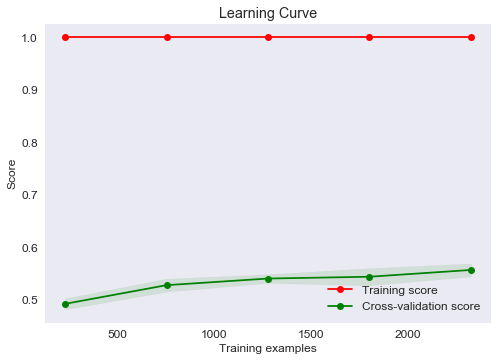

In [10]:
from scikitplot import plotters as skplt
skplt.plot_learning_curve(estimator, X, y)
plt.show()

# feature importances

In [ ]:
cf1= classifier_factory(clf)
cf1.fit(X_train, y_train)
cf1.plot_feature_importances(feature_names=X.columns)
plt.show()

In [116]:
ftr_set=['f11', 'f96', 'f138', 'f156', 'f76', 'f131', 'f185', 'f45'] 
clf = lgb.LGBMClassifier(learning_rate=0.01,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)
cv_score = cross_val_score(clf, X[ftr_set], y, cv=5).mean()
print (cv_score)

0.492375853059


# 25 - 50 - 75 % fi

In [25]:
def get_score(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print ("CVScore:",cv_score)
    clf.fit(X_train,y_train)
    print ("HoldOut:",clf.score(X_test,y_test))

In [26]:
clf = lgb.LGBMClassifier(n_estimators=1500,learning_rate=0.01,max_depth=9,min_child_weight=5,
                               subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)

In [4]:

clf.fit(X,y)
fi=clf.feature_importances_

In [5]:
fi_pf=pd.DataFrame(data=fi,columns=['fi_rank'],index=X.columns)
fi_pf=fi_pf.sort_values(['fi_rank'],ascending=False)
fi_pf['rank']=0
for i in range (fi_pf.shape[0]):
    fi_pf.iloc[i,1]=i
fi_pf.head()

,fi_rank,rank
f11,0.012249,0
f96,0.009489,1
f156,0.008735,2
f21,0.008296,3
f173,0.008098,4


In [6]:
def get_first_ftr(N):
    ftrN=fi_pf[fi_pf['rank']<N].index
    return list(ftrN)

In [27]:
get_score(clf,X,y)

CVScore: 0.559776172449
HoldOut: 0.574021012416


In [18]:
ftr25=get_first_ftr(int(len(X.columns)*0.25))
ftr50=get_first_ftr(int(len(X.columns)*0.5))
ftr75=get_first_ftr(int(len(X.columns)*0.75))

In [19]:
get_score(clf,X[ftr25],y)

CVScore: 0.529059962353
HoldOut: 0.550143266476


In [20]:
get_score(clf,X[ftr50],y)


CVScore: 0.535621660877
HoldOut: 0.567335243553


In [21]:
get_score(clf,X[ftr75],y)

CVScore: 0.548736580275
HoldOut: 0.573065902579


In [55]:
def predict_result(clf,X_test):
    Y_pred=clf.predict(X_test)
    res_file=open('result.csv', 'w')
    for y_item in Y_pred:
      res_file.write("%s\n" % y_item)
    res_file.close()

In [56]:
estimator.fit(Xb,yb)


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.2, drop_rate=0.1,
        is_unbalance=True, learning_rate=0.01, max_bin=255, max_depth=9,
        max_drop=50, min_child_samples=10, min_child_weight=5,
        min_split_gain=0, n_estimators=1500, nthread=-1, num_leaves=31,
        objective='multiclass', reg_alpha=1e-05, reg_lambda=0,
        scale_pos_weight=1, seed=0, sigmoid=1.0, silent=True,
        skip_drop=0.5, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1, uniform_drop=False, xgboost_dart_mode=False)

In [57]:
predict_result(estimator,X_test)